In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as SKLearnDecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor as SKLearnBaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train_data.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Encode categorical columns
for col in df.columns:
    if df[col].dtype == 'object' and col != 'Giá':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

X = df.drop('Giá', axis=1).values
y = df['Giá'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset shape: {df.shape}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Dataset shape: (4773, 20)
Train: (3818, 19), Test: (955, 19)


In [52]:
class DecisionTreeRegressorWrapper:
    def __init__(self, max_depth, random_state=42):
        self.max_depth = max_depth
        self.random_state = random_state
        self.model = SKLearnDecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)


class BaggingRegressor:
    def __init__(self, n_estimators, max_depth, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        np.random.seed(random_state)
    
    def fit(self, X, y):
        self.models = []
        n_samples = X.shape[0]
        
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            tree = DecisionTreeRegressorWrapper(max_depth=self.max_depth, random_state=self.random_state+i)
            tree.fit(X_bootstrap, y_bootstrap)
            self.models.append(tree)
        
        return self
    
    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)
        return np.mean(predictions, axis=1)
    
    def score_rmse(self, X, y):
        y_pred = self.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))
    
    def score_r2(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

In [53]:
print("=" * 70)
print("P1: BAGGING CODE TAY")
print("=" * 70)

results_p1 = []
n_estimators_range = list(range(10, 101, 10))
max_depth_range = list(range(3, 11))

for n_est in n_estimators_range:
    for max_d in max_depth_range:
        model = BaggingRegressor(n_estimators=n_est, max_depth=max_d, random_state=42)
        model.fit(X_train, y_train)
        
        rmse_test = model.score_rmse(X_test, y_test)
        r2_test = model.score_r2(X_test, y_test)
        
        results_p1.append({
            'n_estimators': n_est,
            'max_depth': max_d,
            'rmse_test': rmse_test,
            'r2_test': r2_test
        })
        
        print(f"Trees: {n_est:3d}, Depth: {max_d:2d}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")

df_results_p1 = pd.DataFrame(results_p1)

print("\n" + "=" * 70)
print("BẢNG KẾT QUẢ P1")
print("=" * 70)
print(df_results_p1.to_string(index=False))

P1: BAGGING CODE TAY
Trees:  10, Depth:  3, RMSE: 2.3484, R²: 0.6000
Trees:  10, Depth:  4, RMSE: 1.7918, R²: 0.7672
Trees:  10, Depth:  5, RMSE: 1.2887, R²: 0.8795
Trees:  10, Depth:  6, RMSE: 0.9669, R²: 0.9322
Trees:  10, Depth:  7, RMSE: 0.6986, R²: 0.9646
Trees:  10, Depth:  8, RMSE: 0.5631, R²: 0.9770
Trees:  10, Depth:  9, RMSE: 0.4687, R²: 0.9841
Trees:  10, Depth: 10, RMSE: 0.4216, R²: 0.9871
Trees:  20, Depth:  3, RMSE: 2.3288, R²: 0.6066
Trees:  20, Depth:  4, RMSE: 1.7866, R²: 0.7685
Trees:  20, Depth:  5, RMSE: 1.2660, R²: 0.8838
Trees:  20, Depth:  6, RMSE: 0.9233, R²: 0.9382
Trees:  20, Depth:  7, RMSE: 0.6593, R²: 0.9685
Trees:  20, Depth:  8, RMSE: 0.5140, R²: 0.9808
Trees:  20, Depth:  9, RMSE: 0.4351, R²: 0.9863
Trees:  20, Depth: 10, RMSE: 0.3916, R²: 0.9889
Trees:  30, Depth:  3, RMSE: 2.3200, R²: 0.6096
Trees:  30, Depth:  4, RMSE: 1.7534, R²: 0.7770
Trees:  30, Depth:  5, RMSE: 1.2472, R²: 0.8872
Trees:  30, Depth:  6, RMSE: 0.9109, R²: 0.9398
Trees:  30, Depth: 


BEST MODEL P1
Best n_estimators: 70
Best max_depth: 10
RMSE train: 0.1826, R²: 0.9977
RMSE test:  0.3707, R²: 0.9900


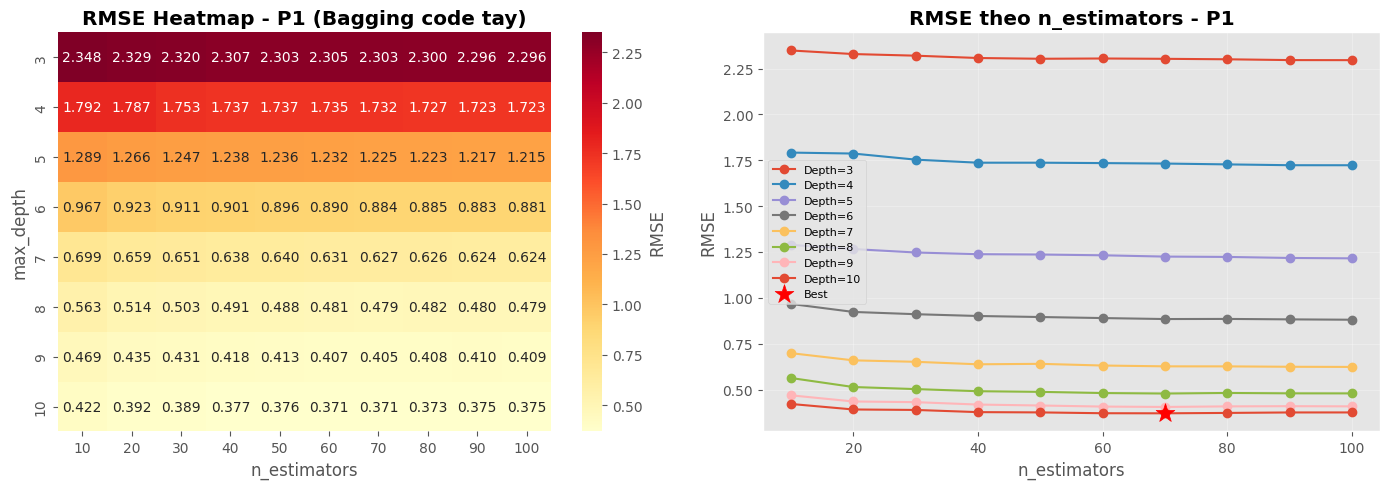

In [56]:
best_p1 = df_results_p1.loc[df_results_p1['rmse_test'].idxmin()]
best_n_est_p1 = int(best_p1['n_estimators'])
best_depth_p1 = int(best_p1['max_depth'])
best_rmse_test_p1 = best_p1['rmse_test']

best_model_p1 = BaggingRegressor(n_estimators=best_n_est_p1, max_depth=best_depth_p1, random_state=42)
best_model_p1.fit(X_train, y_train)
best_rmse_train_p1 = best_model_p1.score_rmse(X_train, y_train)
best_rmse_test_p1_rerun = best_model_p1.score_rmse(X_test, y_test)
best_r2_train_p1 = best_model_p1.score_r2(X_train, y_train)
best_r2_test_p1 = best_model_p1.score_r2(X_test, y_test)

print("\n" + "=" * 70)
print("BEST MODEL P1")
print("=" * 70)
print(f"Best n_estimators: {best_n_est_p1}")
print(f"Best max_depth: {best_depth_p1}")
print(f"RMSE train: {best_rmse_train_p1:.4f}, R²: {best_r2_train_p1:.4f}")
print(f"RMSE test:  {best_rmse_test_p1_rerun:.4f}, R²: {best_r2_test_p1:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pivot_data = df_results_p1.pivot(index='max_depth', columns='n_estimators', values='rmse_test')
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'RMSE'}, ax=axes[0])
axes[0].set_title('RMSE Heatmap - P1 (Bagging code tay)', fontweight='bold')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('max_depth')

for depth in max_depth_range:
    subset = df_results_p1[df_results_p1['max_depth'] == depth]
    axes[1].plot(subset['n_estimators'], subset['rmse_test'], marker='o', label=f'Depth={depth}')
axes[1].scatter([best_n_est_p1], [best_rmse_test_p1], color='red', s=200, marker='*', zorder=5, label='Best')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE theo n_estimators - P1', fontweight='bold')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [57]:
print("\n" + "=" * 70)
print("P2: BAGGING SKLEARN")
print("=" * 70)

results_p2 = []

for n_est in n_estimators_range:
    for max_d in max_depth_range:
        base_est = SKLearnDecisionTreeRegressor(max_depth=max_d, random_state=42)
        try:
            model = SKLearnBaggingRegressor(
                estimator=base_est,
                n_estimators=n_est,
                bootstrap=True,
                random_state=42,
                n_jobs=-1
            )
        except TypeError:
            model = SKLearnBaggingRegressor(
                base_estimator=base_est,
                n_estimators=n_est,
                bootstrap=True,
                random_state=42,
                n_jobs=-1
            )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_test = r2_score(y_test, y_pred)
        
        results_p2.append({
            'n_estimators': n_est,
            'max_depth': max_d,
            'rmse_test': rmse_test,
            'r2_test': r2_test
        })
        
        print(f"Trees: {n_est:3d}, Depth: {max_d:2d}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")

df_results_p2 = pd.DataFrame(results_p2)

print("\n" + "=" * 70)
print("BẢNG KẾT QUẢ P2")
print("=" * 70)
print(df_results_p2.to_string(index=False))


P2: BAGGING SKLEARN
Trees:  10, Depth:  3, RMSE: 2.3174, R²: 0.6105
Trees:  10, Depth:  4, RMSE: 1.7641, R²: 0.7743
Trees:  10, Depth:  5, RMSE: 1.2858, R²: 0.8801
Trees:  10, Depth:  6, RMSE: 0.9320, R²: 0.9370
Trees:  10, Depth:  7, RMSE: 0.6922, R²: 0.9652
Trees:  10, Depth:  8, RMSE: 0.5431, R²: 0.9786
Trees:  10, Depth:  9, RMSE: 0.4438, R²: 0.9857
Trees:  10, Depth: 10, RMSE: 0.4264, R²: 0.9868
Trees:  20, Depth:  3, RMSE: 2.2353, R²: 0.6376
Trees:  20, Depth:  4, RMSE: 1.6901, R²: 0.7928
Trees:  20, Depth:  5, RMSE: 1.2213, R²: 0.8918
Trees:  20, Depth:  6, RMSE: 0.8788, R²: 0.9440
Trees:  20, Depth:  7, RMSE: 0.6274, R²: 0.9715
Trees:  20, Depth:  8, RMSE: 0.4958, R²: 0.9822
Trees:  20, Depth:  9, RMSE: 0.4021, R²: 0.9883
Trees:  20, Depth: 10, RMSE: 0.3828, R²: 0.9894
Trees:  30, Depth:  3, RMSE: 2.2617, R²: 0.6290
Trees:  30, Depth:  4, RMSE: 1.6978, R²: 0.7909
Trees:  30, Depth:  5, RMSE: 1.2146, R²: 0.8930
Trees:  30, Depth:  6, RMSE: 0.8707, R²: 0.9450
Trees:  30, Depth: 


BEST MODEL P2
Best n_estimators: 40
Best max_depth: 10
RMSE train: 0.1835, R²: 0.9976
RMSE test:  0.3702, R²: 0.9901


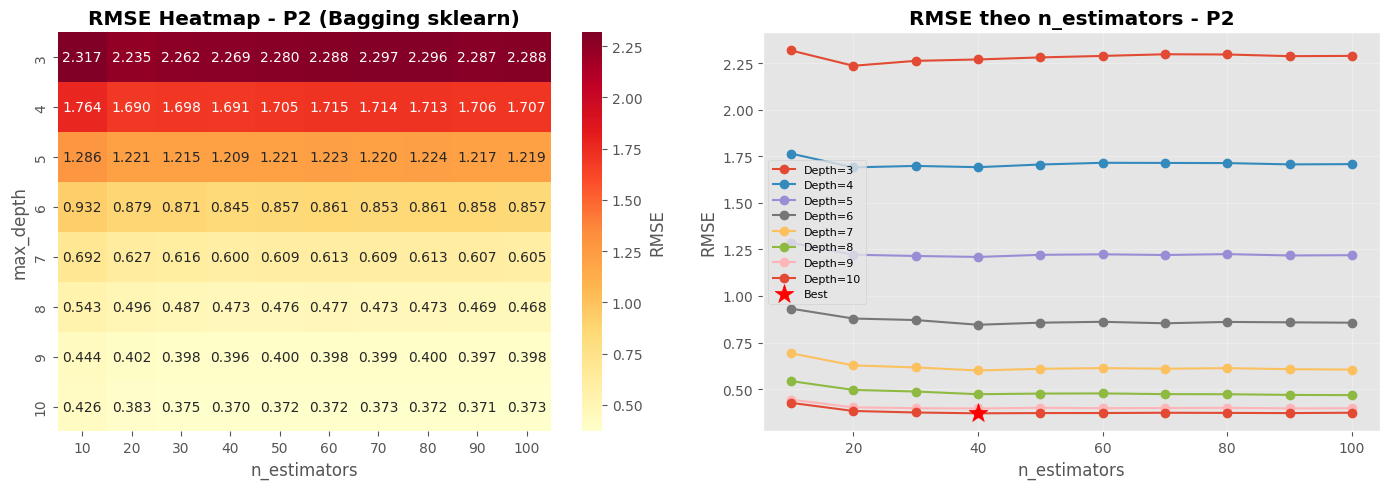

In [60]:
best_p2 = df_results_p2.loc[df_results_p2['rmse_test'].idxmin()]
best_n_est_p2 = int(best_p2['n_estimators'])
best_depth_p2 = int(best_p2['max_depth'])
best_rmse_test_p2 = best_p2['rmse_test']

base_est_best = SKLearnDecisionTreeRegressor(max_depth=best_depth_p2, random_state=42)
try:
    best_model_p2 = SKLearnBaggingRegressor(
        estimator=base_est_best,
        n_estimators=best_n_est_p2,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
except TypeError:
    best_model_p2 = SKLearnBaggingRegressor(
        base_estimator=base_est_best,
        n_estimators=best_n_est_p2,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

best_model_p2.fit(X_train, y_train)
y_train_pred = best_model_p2.predict(X_train)
y_test_pred = best_model_p2.predict(X_test)
best_rmse_train_p2 = np.sqrt(mean_squared_error(y_train, y_train_pred))
best_rmse_test_p2_rerun = np.sqrt(mean_squared_error(y_test, y_test_pred))
best_r2_train_p2 = r2_score(y_train, y_train_pred)
best_r2_test_p2 = r2_score(y_test, y_test_pred)

print("\n" + "=" * 70)
print("BEST MODEL P2")
print("=" * 70)
print(f"Best n_estimators: {best_n_est_p2}")
print(f"Best max_depth: {best_depth_p2}")
print(f"RMSE train: {best_rmse_train_p2:.4f}, R²: {best_r2_train_p2:.4f}")
print(f"RMSE test:  {best_rmse_test_p2_rerun:.4f}, R²: {best_r2_test_p2:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pivot_data = df_results_p2.pivot(index='max_depth', columns='n_estimators', values='rmse_test')
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'RMSE'}, ax=axes[0])
axes[0].set_title('RMSE Heatmap - P2 (Bagging sklearn)', fontweight='bold')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('max_depth')

for depth in max_depth_range:
    subset = df_results_p2[df_results_p2['max_depth'] == depth]
    axes[1].plot(subset['n_estimators'], subset['rmse_test'], marker='o', label=f'Depth={depth}')
axes[1].scatter([best_n_est_p2], [best_rmse_test_p2], color='red', s=200, marker='*', zorder=5, label='Best')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE theo n_estimators - P2', fontweight='bold')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


SO SÁNH P1 vs P2

P1 (Bagging code tay):
  Best config: n_estimators=70, max_depth=10
  RMSE test: 0.3707
  R² test:   0.9900

P2 (Bagging sklearn):
  Best config: n_estimators=40, max_depth=10
  RMSE test: 0.3702
  R² test:   0.9901

KẾT LUẬN:
  P2 tốt hơn P1 với RMSE test thấp hơn 0.0005


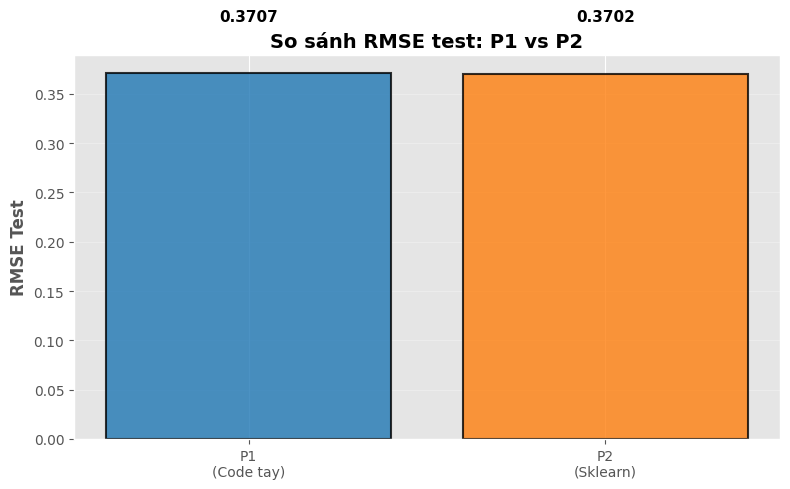

In [61]:
print("\n" + "=" * 70)
print("SO SÁNH P1 vs P2")
print("=" * 70)

print("\nP1 (Bagging code tay):")
print(f"  Best config: n_estimators={best_n_est_p1}, max_depth={best_depth_p1}")
print(f"  RMSE test: {best_rmse_test_p1_rerun:.4f}")
print(f"  R² test:   {best_r2_test_p1:.4f}")

print("\nP2 (Bagging sklearn):")
print(f"  Best config: n_estimators={best_n_est_p2}, max_depth={best_depth_p2}")
print(f"  RMSE test: {best_rmse_test_p2_rerun:.4f}")
print(f"  R² test:   {best_r2_test_p2:.4f}")

print("\nKẾT LUẬN:")
if best_rmse_test_p1_rerun < best_rmse_test_p2_rerun:
    print(f"  P1 tốt hơn P2 với RMSE test thấp hơn {best_rmse_test_p2_rerun - best_rmse_test_p1_rerun:.4f}")
else:
    print(f"  P2 tốt hơn P1 với RMSE test thấp hơn {best_rmse_test_p1_rerun - best_rmse_test_p2_rerun:.4f}")

fig, ax = plt.subplots(figsize=(8, 5))
methods = ['P1\n(Code tay)', 'P2\n(Sklearn)']
rmse_values = [best_rmse_test_p1_rerun, best_rmse_test_p2_rerun]
colors = ['#1f77b4', '#ff7f0e']
bars = ax.bar(methods, rmse_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('RMSE Test', fontsize=12, fontweight='bold')
ax.set_title('So sánh RMSE test: P1 vs P2', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, rmse_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.4f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [64]:
print("\n" + "=" * 70)
print("DỰ ĐOÁN TRÊN TEST DATA PRIVATE")
print("=" * 70)

# Load test data
df_test = pd.read_csv('test_data.csv')
print(f"\nTest data shape: {df_test.shape}")
print(f"Columns: {list(df_test.columns)}")

# Preprocess test data giống train data
df_test_processed = df_test.copy()
df_test_processed.dropna(inplace=True)
df_test_processed.reset_index(drop=True, inplace=True)

# Encode categorical columns
for col in df_test_processed.columns:
    if df_test_processed[col].dtype == 'object':
        le = LabelEncoder()
        df_test_processed[col] = le.fit_transform(df_test_processed[col].astype(str))

# Lưu giá thực để so sánh
y_true_private = None
if 'Giá' in df_test_processed.columns:
    print("\n⚠️  Test data có cột 'Giá' - sẽ bỏ để dự đoán và dùng để đánh giá")
    y_true_private = df_test_processed['Giá'].values
    X_test_private = df_test_processed.drop('Giá', axis=1).values
else:
    print("\n✓ Test data không có cột 'Giá' - dùng toàn bộ làm features")
    X_test_private = df_test_processed.values

print(f"X_test_private shape: {X_test_private.shape}")

# Dùng model tốt nhất (P2 có RMSE thấp hơn)
print(f"\nSử dụng model: P2 (sklearn) - Best model")
print(f"Config: n_estimators={best_n_est_p2}, max_depth={best_depth_p2}")

# Dự đoán
y_pred_private = best_model_p2.predict(X_test_private)

# Đánh giá nếu có giá thực
if y_true_private is not None:
    rmse_private = np.sqrt(mean_squared_error(y_true_private, y_pred_private))
    r2_private = r2_score(y_true_private, y_pred_private)
    
    print("\n" + "=" * 70)
    print("ĐÁNH GIÁ TRÊN TEST DATA PRIVATE")
    print("=" * 70)
    print(f"RMSE: {rmse_private:.4f}")
    print(f"R²:   {r2_private:.4f}")
    
    # So sánh với kết quả trên validation set
    print("\n" + "=" * 70)
    print("SO SÁNH: VALIDATION SET vs PRIVATE TEST SET")
    print("=" * 70)
    print(f"Validation set (từ train_data.csv - 80/20 split):")
    print(f"  RMSE: {best_rmse_test_p2_rerun:.4f}")
    print(f"  R²:   {best_r2_test_p2:.4f}")
    print(f"\nPrivate test set (test_data.csv):")
    print(f"  RMSE: {rmse_private:.4f}")
    print(f"  R²:   {r2_private:.4f}")
    
    diff_rmse = rmse_private - best_rmse_test_p2_rerun
    diff_r2 = r2_private - best_r2_test_p2
    print(f"\nChênh lệch:")
    print(f"  RMSE: {diff_rmse:+.4f} {'(tốt hơn)' if diff_rmse < 0 else '(kém hơn)'}")
    print(f"  R²:   {diff_r2:+.4f} {'(tốt hơn)' if diff_r2 > 0 else '(kém hơn)'}")

# Tạo DataFrame kết quả
if y_true_private is not None:
    df_result = pd.DataFrame({
        'Index': range(len(y_pred_private)),
        'Giá_Thực': y_true_private,
        'Giá_Dự_Đoán': y_pred_private,
        'Sai_Số': np.abs(y_true_private - y_pred_private)
    })
else:
    df_result = pd.DataFrame({
        'Index': range(len(y_pred_private)),
        'Giá_Dự_Đoán': y_pred_private
    })

# Lưu kết quả
output_file = 'test_predictions.csv'
df_result.to_csv(output_file, index=False)

print(f"\n✅ Đã lưu kết quả dự đoán vào file: {output_file}")
print(f"Số dòng dự đoán: {len(y_pred_private)}")
print(f"\nMẫu 10 dự đoán đầu tiên:")
print(df_result.head(10).to_string(index=False))


DỰ ĐOÁN TRÊN TEST DATA PRIVATE

Test data shape: (1194, 20)
Columns: ['Diện tích (m2)', 'Hướng', 'Chiều ngang (m)', 'Chiều dài (m)', 'Số phòng ngủ', 'Số phòng vệ sinh', 'Số tầng', 'Tình trạng nội thất', 'Giá_per_m2', 'Tổng_phòng', 'Aspect_ratio', 'Diện_tích_per_phòng', 'Thành phố_encoded', 'Phường/Xã_encoded', 'Loại hình_Nhà biệt thự', 'Loại hình_Nhà mặt phố, mặt tiền', 'Loại hình_Nhà ngõ, hẻm', 'Loại hình_Nhà phố liền kề', 'Giấy tờ pháp lý_encoded', 'Giá']

⚠️  Test data có cột 'Giá' - sẽ bỏ để dự đoán và dùng để đánh giá
X_test_private shape: (1194, 19)

Sử dụng model: P2 (sklearn) - Best model
Config: n_estimators=40, max_depth=10

ĐÁNH GIÁ TRÊN TEST DATA PRIVATE
RMSE: 0.4024
R²:   0.9881

SO SÁNH: VALIDATION SET vs PRIVATE TEST SET
Validation set (từ train_data.csv - 80/20 split):
  RMSE: 0.3702
  R²:   0.9901

Private test set (test_data.csv):
  RMSE: 0.4024
  R²:   0.9881

Chênh lệch:
  RMSE: +0.0322 (kém hơn)
  R²:   -0.0019 (kém hơn)

✅ Đã lưu kết quả dự đoán vào file: test_pr